# Exercise 1 Digit Classification: Dennis Shushack  15-703-341


## Finished Functions: 
Here you can find the finished functions for the exercise. Please refer to the section Exploration in order to see the development process of the functions.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import 

### Exploration
In this first part of the notebook, we will explore the images before using a proper function to do everything automatically. This involves tuning the parameters appropriately and so on. In order to do so, we will use a sample of five images. In this part we will load the five images and then set them to greyscale and resize them accordingly.

In [95]:
# Libraries Needed:
import numpy as np
import skimage
import skimage.io
import skimage.data
import skimage.feature
import matplotlib.pyplot as plt
import ipywidgets as widgets
from keras.datasets import mnist
from skimage import io, color, feature, transform, measure, exposure
import tensorflow as tf
%matplotlib inline 

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')
print(tf.__version__)


2.14.0


Original Shape: (3024, 4032)
Resized Shape: (500, 667)


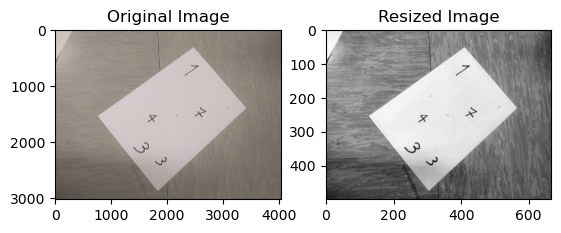

Original Shape: (3024, 4032)
Resized Shape: (500, 667)


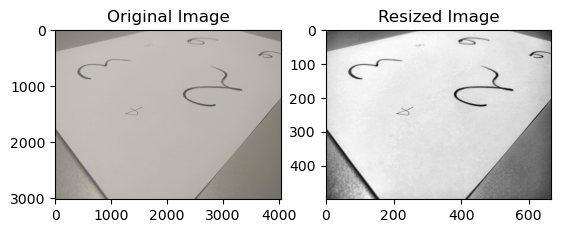

Original Shape: (4032, 3024)
Resized Shape: (500, 375)


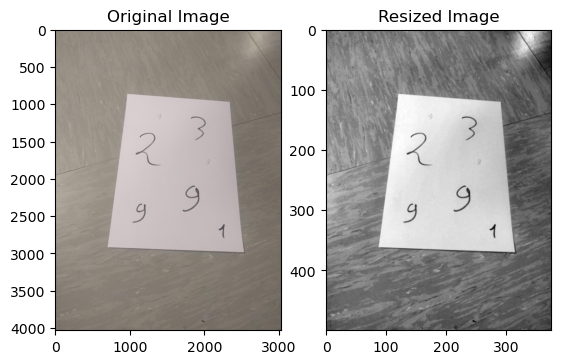

Original Shape: (4032, 3024)
Resized Shape: (500, 375)


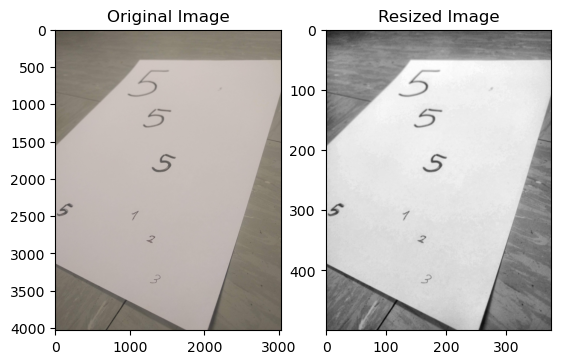

Original Shape: (3024, 4032)
Resized Shape: (500, 667)


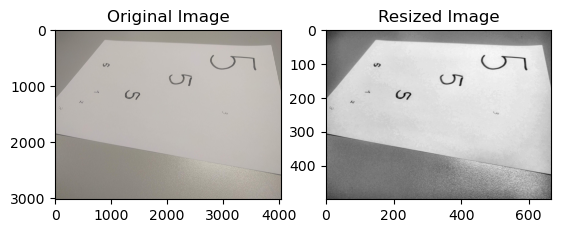

In [96]:
def prepare_image(im):
    """This function takes an image and returns a grayscale image 
    and resizes it to 500 pixels in height, while keeping the aspect ratio.
    """
    # Converts the image to grayscale:
    gray_im = skimage.color.rgb2gray(im)
    print(f"Original Shape: {gray_im.shape}")

    # Equalizes the image: 
    gray_im = exposure.equalize_adapthist(gray_im)


    # Resizes the image and keeps the aspect ratio:
    resized_image = skimage.transform.resize(gray_im, (500, im.shape[1]/im.shape[0]*500))
    print(f"Resized Shape: {resized_image.shape}")

    # Draws the images original and resized grayscale image:
    plt.subplot(1,2,1)
    plt.imshow(im, cmap='gray')
    plt.title("Original Image")
    plt.subplot(1,2,2)
    plt.imshow(resized_image, cmap='gray')
    plt.title("Resized Image")
    plt.show()

    return resized_image

# Prepares the images:
# Loads the image and converts it to a floating point: 
im1 = skimage.io.imread("./Images_1/IMG_20190312_183913.jpg")
im2 = skimage.io.imread("./Images_1/IMG_20190312_185240.jpg")
im3 = skimage.io.imread("./Images_1/IMG_20190312_183849.jpg")
im4 = skimage.io.imread("./Images_1/IMG_20190312_183902.jpg")
im5 = skimage.io.imread("./Images_1/IMG_20190312_185258.jpg")

# Prepares the images:
im1 = prepare_image(im1)
im2 = prepare_image(im2)
im3 = prepare_image(im3)
im4 = prepare_image(im4)
im5 = prepare_image(im5)

images = [im1, im2, im3, im4, im5]

We apply Canny Edge Detector in order to detect the edges:
* `sigma`: Determines the standard deviation of the Gaussian Filter applied: Higher Sigma = stronger smoothing (=reduces noise, however can blur out details)
* `low_threshhold`: Determines the lower bound for the edge detection. (Lower=Weaker edges can be detected)
* `high_threshhold`: Determines the upper bound for edge detection (Too high=only strong edges above threshhold remain).

We need to find a good balance between the threshholds and sigma in order to capture the edges of the paper. We use the widget to find a good balance of the parameters.

In [4]:
@widgets.interact(sigma=(0.0,4.0),
                  low_threshold=(0.0,1.0,0.01),
                  high_threshold=(0.1,1.0,0.01))
def f(sigma, low_threshold, high_threshold):
    """
    This function adjusts the different sigma and threshold values for the canny edge detection.
    """
    fig, axs = plt.subplots(len(images), 2, figsize=(15, 10 * len(images)))
    for i, img in enumerate(images):
        im_edges = skimage.feature.canny(img, sigma=sigma, 
                                         low_threshold=low_threshold, 
                                         high_threshold=high_threshold)
        
        axs[i][0].imshow(img, cmap="gray")
        axs[i][0].axis('off')
        axs[i][1].imshow(im_edges, cmap="gray")
        axs[i][1].axis('off')
    
    plt.tight_layout()
    plt.show()


interactive(children=(FloatSlider(value=2.0, description='sigma', max=4.0), FloatSlider(value=0.5, description…

Some decent values are achieved with these specific pictures at a Sigma value of `2` and a `low_threshhold` of `0` and `high_threshhold` of `0.2`. We will thus try it with this setting to see how well it will perfom.

#### Hough Transform:
We use the edge map (Cany) and then apply hough transform to find the lines in our image. We then transform the polar coordinates into cartesian coordinates in order to detect the corners of the paper. 

Lines: [array([   0.68199836,    0.7313537 , -555.        ]), array([ 0.77714596, -0.62932039, 64.        ]), array([   0.75470958,   -0.65605903, -274.        ]), array([   0.58778525,    0.80901699, -282.        ])]
Intersections: [(303.20477171390945, 476.1237170975741), (564.8477653303477, 232.13767836802558), (1991.9914331074997, -1098.695321920004), (-6143.97298708556, -7485.477764919917), (125.86375453730972, 257.12579924915747), (408.2327515023626, 51.972714363829915)]


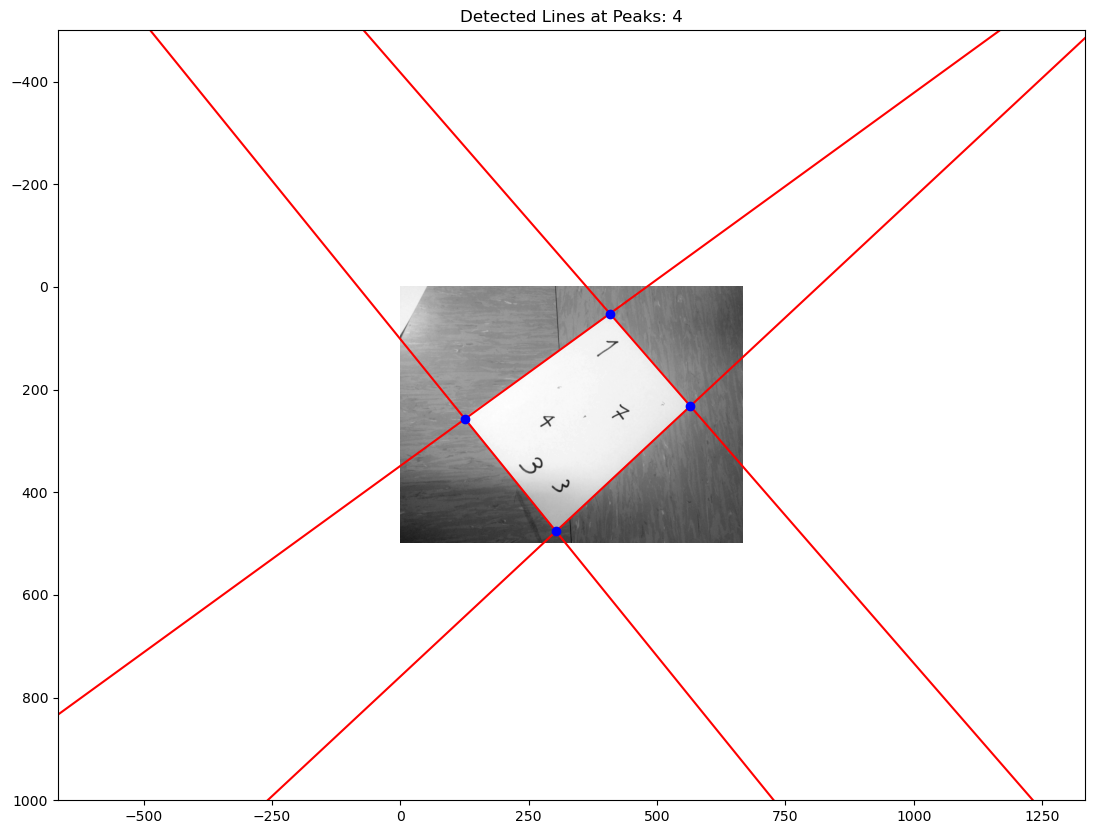

Lines: [array([   0.76604444,    0.64278761, -639.        ]), array([  0.79863551,  -0.60181502, 175.        ]), array([   0.75470958,    0.65605903, -637.        ]), array([  0.22495105,   0.97437006, -66.        ])]
Intersections: [(279.2285784754511, 661.3358638107103), (559.5796883199736, 327.22642146572775), (964.0810994043048, -154.83958840345235), (274.54531348137346, 655.1209612520436), (-143.17291899945153, 100.790143941934), (982.2870395317929, -159.0427608684258)]


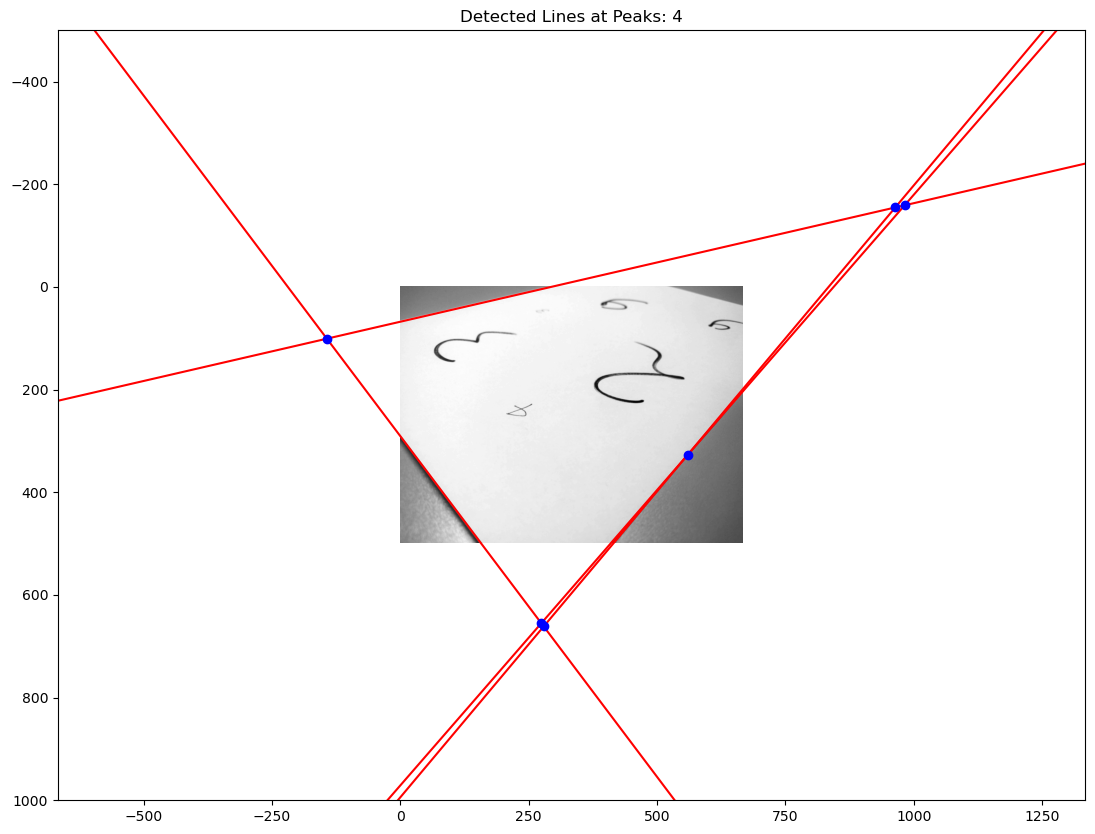

Lines: [array([ 9.96194698e-01, -8.71557427e-02, -2.78000000e+02]), array([ 3.48994967e-02, -9.99390827e-01,  3.59000000e+02]), array([ 9.92546152e-01,  1.21869343e-01, -1.32000000e+02]), array([ 9.92546152e-01,  1.21869343e-01, -1.31000000e+02])]
Intersections: [(311.44099551093205, 370.09458561779473), (218.2861162391416, -694.6705567161899), (217.86692026990647, -699.4619885696538), (88.50528421097131, 362.3094990320099), (87.5020758733507, 362.2744662248997)]


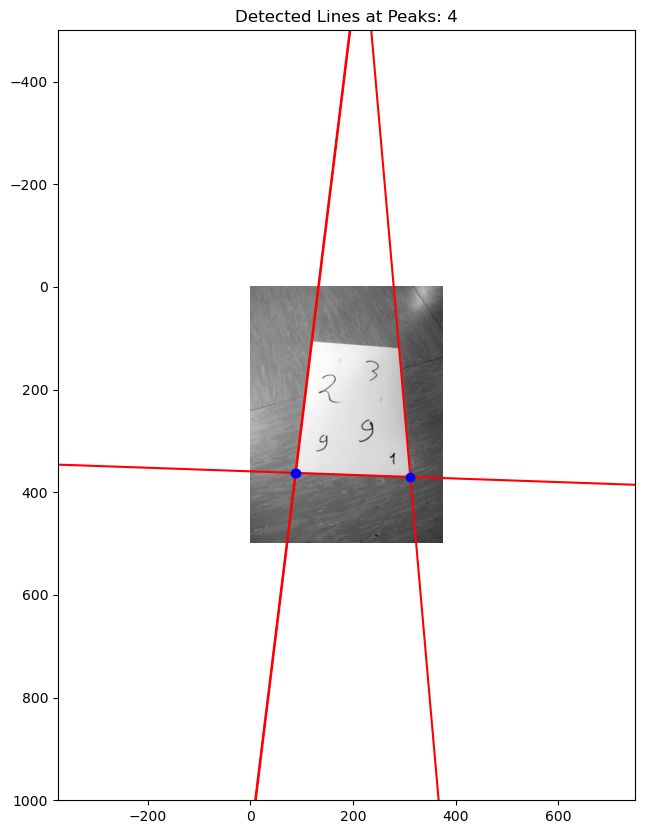

Lines: [array([ 9.56304756e-01,  2.92371705e-01, -3.89000000e+02]), array([ 6.123234e-17, -1.000000e+00,  5.100000e+01]), array([  0.4539905 ,  -0.89100652, 347.        ]), array([ 9.61261696e-01,  2.75637356e-01, -3.88000000e+02])]
Intersections: [(391.1818285191089, 51.00000000000003), (248.93036800396357, 516.2835621091564), (356.2425641387309, 165.28118438647022), (-664.2400390303249, 50.99999999999996), (389.0121664406024, 51.00000000000002), (254.74474742876794, 519.2461363991109)]


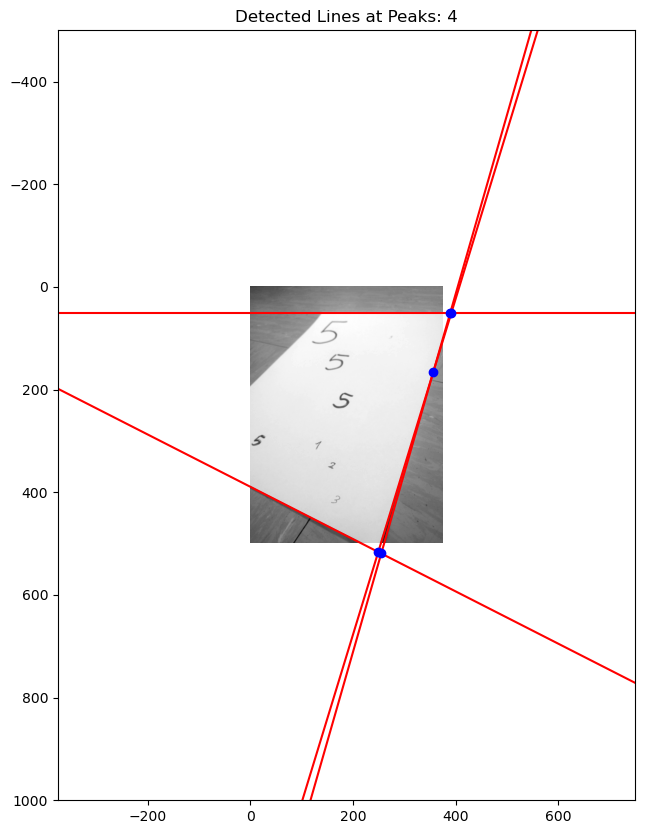

Lines: [array([ 1.73648178e-01, -9.84807753e-01,  3.04000000e+02]), array([ 0.0348995 , -0.99939083, 28.        ]), array([   0.76604444,    0.64278761, -133.        ]), array([ 1.90808995e-01, -9.81627183e-01,  3.00000000e+02])]
Intersections: [(-1984.8677109575087, -41.29604056559332), (-74.39504882020873, 295.5718356751403), (170.3110614062748, 338.7201252522893), (145.83674955744453, 33.109798755088285), (-1740.8675696826622, -32.7753678761805), (-71.20793986122291, 291.7735871232797)]


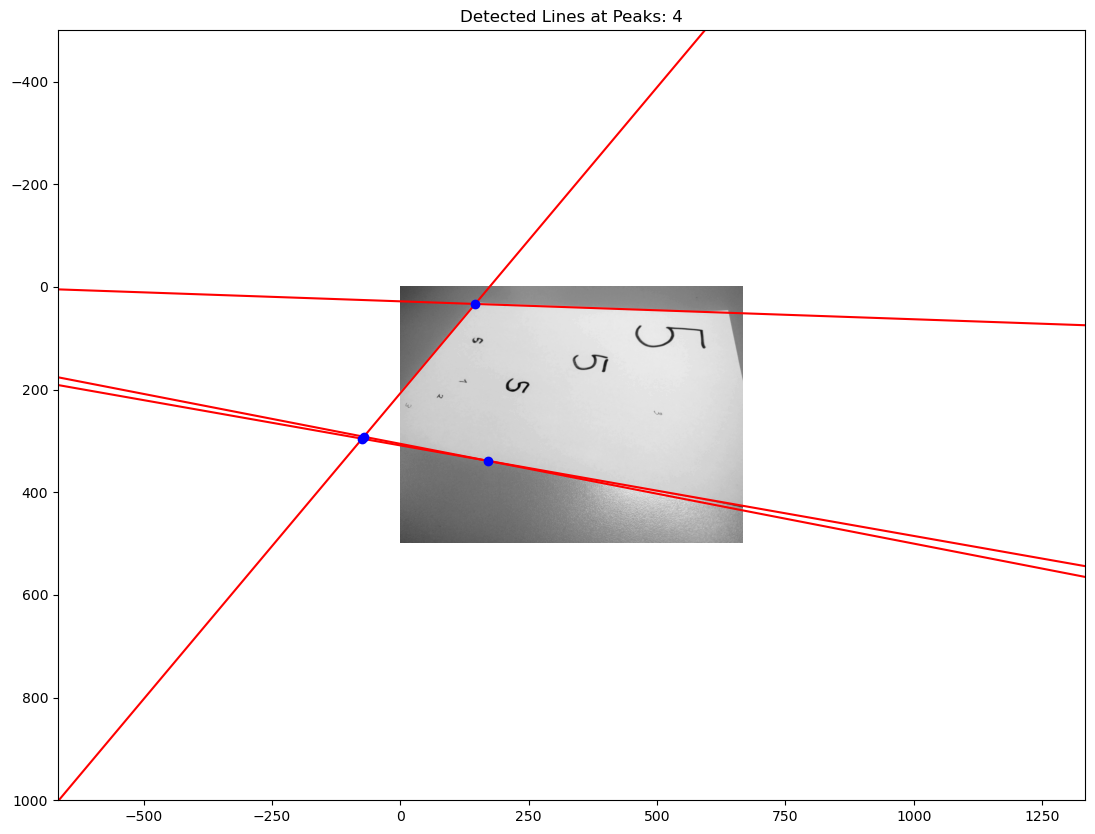

In [5]:
import numpy as np
import skimage.feature
from skimage.transform import hough_line
import matplotlib.pyplot as plt


# Convert polar coordinates xcos(θ)+ysin(θ)−ρ=0 into a line equation of the form Ax + By + C = 0
def polar_to_homogeneous(theta, rho):
    A = np.cos(theta)
    B = np.sin(theta)
    C = -rho
    return np.array([A, B, C])

# Find intersection of two lines using the cross product:
def intersection(l1, l2):
    return np.cross(l1, l2)

def plot_hough_lines_and_intersections(im, sigma=2, low_threshold=0.0, high_threshold=0.2, peaks=4):
    """
    Applies Canny edge detection and Hough transform to detect lines in an image and plot them.
    Additionally plot the intersections of the detected lines.

    Parameters:
    - im: Input grayscale image
    - sigma, low_threshold, high_threshold: Parameters for Canny edge detection
    - peaks: Number of peaks to detect in the Hough transform accumulator. 
    """

    # Edge detection
    edges = skimage.feature.canny(im, sigma=sigma, low_threshold=low_threshold, high_threshold=high_threshold)

    # Hough transform (H=accumulator, angles=theta, distances=rho)
    h, angles, distances = hough_line(edges)

    # Finding the peaks in the Hough transform
    sorted_indices = np.argsort(h.ravel())[::-1]
    top_peaks = sorted_indices[:peaks]
    rows, cols = np.unravel_index(top_peaks, h.shape)
    angles = angles[cols]
    distances = distances[rows]

    # Converting the polar coordinates to homogeneous coordinates lines
    lines = []
    for theta, rho in zip(angles, distances):
        line = polar_to_homogeneous(theta, rho)
        lines.append(line)

    # Find the intersections of the lines:
    intersections = []
    for i in range(len(lines)):
        for j in range(i+1, len(lines)):
            pt = intersection(lines[i], lines[j])
            #Needed for the case:  x = X/Z, y = Y/Z thus check if Z != 0
            if pt[2] != 0:  
                intersections.append((pt[0]/pt[2], pt[1]/pt[2]))

    print(f"Lines: {lines}")
    print(f"Intersections: {intersections}")
    
    # Plotting 
    fig, ax = plt.subplots(figsize=(15, 10))
    ax.imshow(im, cmap='gray')
    ax.set_xlim([-im.shape[1], 2*im.shape[1]])
    ax.set_ylim([2*im.shape[0], -im.shape[0]])

    # Plotting the detected lines:
    for angle, dist in zip(angles, distances):
        x0 = -2 * im.shape[1]
        x1 = 3 * im.shape[1]
        y0 = (dist - x0 * np.cos(angle)) / np.sin(angle)
        y1 = (dist - x1 * np.cos(angle)) / np.sin(angle)
        ax.plot([x0, x1], [y0, y1], '-r')
    
    # Plotting the intersections:
    for x, y in intersections:
        ax.plot(x, y, 'bo')  # Plot intersections as blue dots
    plt.title(f"Detected Lines at Peaks: {peaks}")
    plt.show()

# Example usage:
for im in images:
    plot_hough_lines_and_intersections(im, peaks=4)


We can see, that our lines are not all detected (We have some wrong ones) in there. In order to improve our edge detection, we can either increase the number of peaks and manually filter them based on certain criteria (min angle and distance) or we can use the handy function directly, which will make our lifes much easier: `hough_line_peaks`. It takes the following parameters besides H, theta and d:
* `threshhold`: Minimum intensity of peaks (Only those are considered)
* `min_angle`: Minimum angle between peaks. We need this to avoid identifying lines that are too close to each other as seperate lines.
* `min_distance`: Minimum distance between peaks. We need this to avoid identifying lines that are too close to each other as seperate lines.
* `num_peaks`: Maximum number of peaks.

By testing different parameters the best set was identified as: 
threshold=50, min_distance=10,  min_angle=10. Like this we end up with 6 corner points (if lines not parallel). As we need only the four corners of the paper, I removed the last two points by finding the center of the image. The two points furthest away from the center were removed (not part of the paper corners).

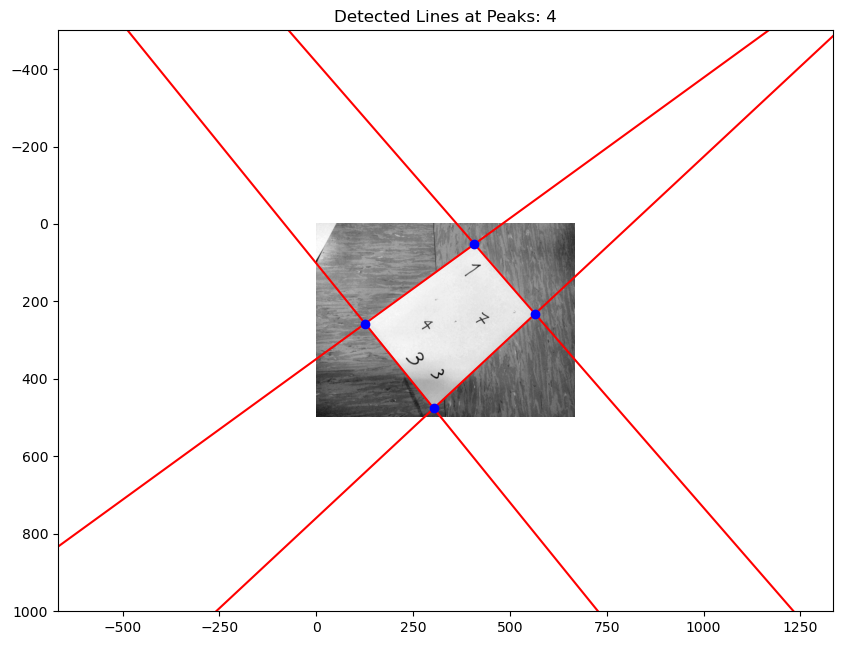

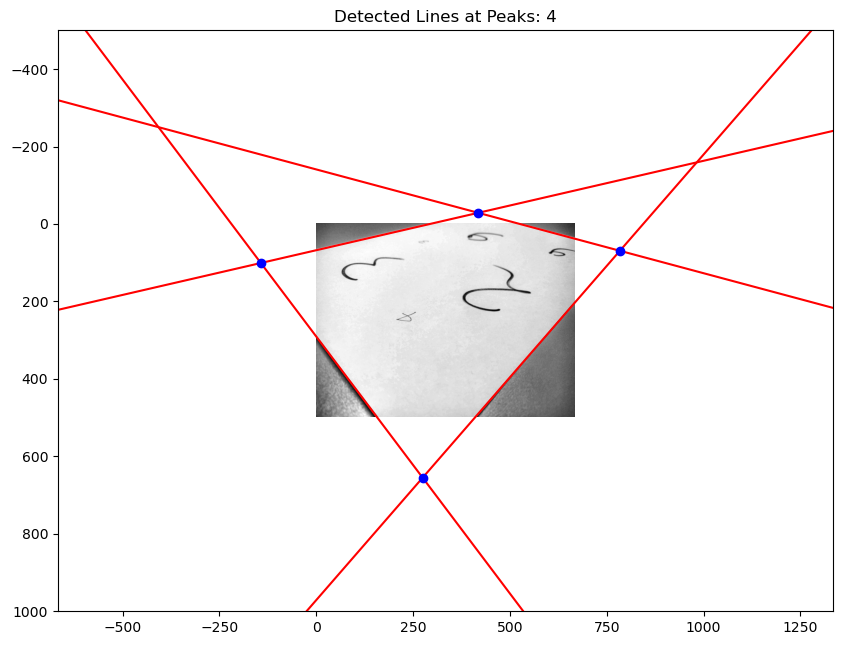

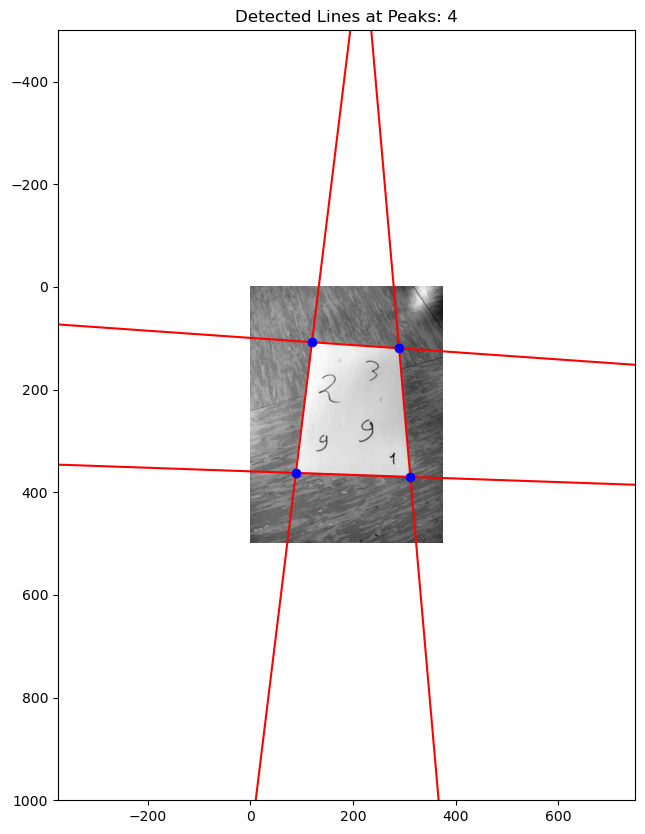

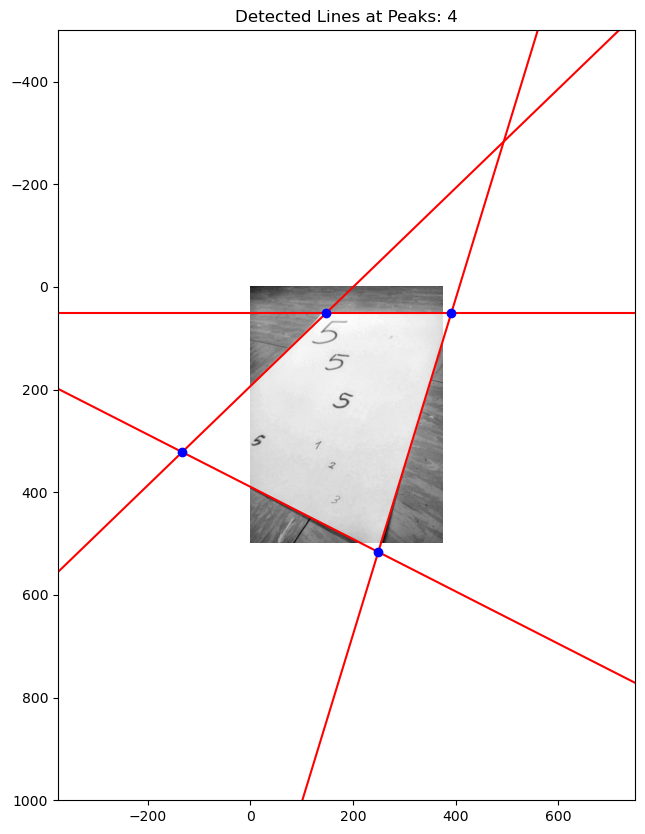

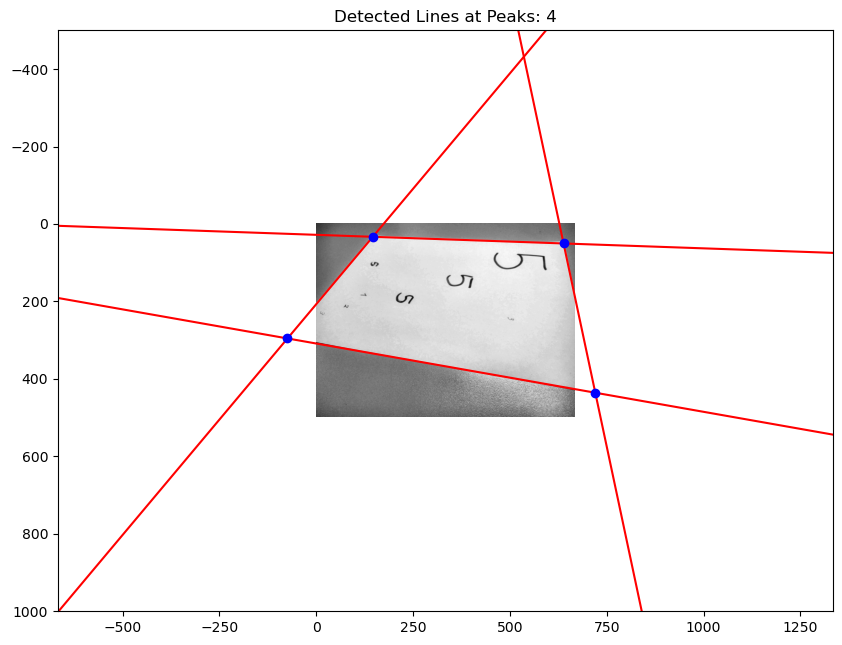

In [97]:

import numpy as np
import skimage.feature
from skimage.transform import hough_line, hough_line_peaks
import matplotlib.pyplot as plt

def distance_from_center(point, center):
    """
    Calculate the distance of a point from the center of the image.
    """
    return ((point[0] - center[0])**2 + (point[1] - center[1])**2)

# Convert polar coordinates xcos(θ)+ysin(θ)−ρ=0 into a line equation Ax + By + C = 0
def polar_to_homogeneous(theta, rho):
    A = np.cos(theta)
    B = np.sin(theta)
    C = -rho
    return np.array([A, B, C])

# Find intersection of two lines
def intersection(l1, l2):
    return np.cross(l1, l2)

def plot_hough_lines_and_intersections(im, sigma=2, low_threshold=0.0, high_threshold=0.25, peaks=4):
    """
    Apply Hough transform to detect lines in an image and plot them.
    Additionally plot the intersections of the detected lines.
    """

    # Edge detection
    im1_edges = skimage.feature.canny(im, sigma=sigma, low_threshold=low_threshold, high_threshold=high_threshold, mode='nearest')

    # Hough transform
    accumulator, angles, distances = hough_line(im1_edges)

    # Finding the peaks in the Hough transform with thresholds
    detected_accumulator, detected_angles, detected_distances = hough_line_peaks(
        accumulator, angles, distances, 
        threshold=50,
        min_distance=10,
        min_angle=10,
        num_peaks=peaks
    )

    # Converting the polar coordinates to homogeneous coordinates lines
    lines = []
    for theta, rho in zip(detected_angles, detected_distances):
        line = polar_to_homogeneous(theta, rho)
        lines.append(line)

    # Find intersections
    intersections = []
    for i in range(len(lines)):
        for j in range(i+1, len(lines)):
            pt = intersection(lines[i], lines[j])
            if pt[2] != 0:  
                intersections.append((pt[0]/pt[2], pt[1]/pt[2]))

   
    # Filter out 2 intersections furthest away from the origin of the image (Keep the 4 closest to the center)
    image_center = (im.shape[1] / 2, im.shape[0] / 2)
    filtered_intersections = sorted(intersections, key=lambda x: distance_from_center(x, image_center))[:-2]

    # Plotting
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.set_xlim([-im.shape[1], 2*im.shape[1]])
    ax.set_ylim([2*im.shape[0], -im.shape[0]])
    ax.imshow(im, cmap='gray')
    for angle, dist in zip(detected_angles, detected_distances):
        x0 = -2 * im.shape[1]
        x1 = 3 * im.shape[1]
        y0 = (dist - x0 * np.cos(angle)) / np.sin(angle)
        y1 = (dist - x1 * np.cos(angle)) / np.sin(angle)
        ax.plot([x0, x1], [y0, y1], '-r')
    for x, y in filtered_intersections:
        ax.plot(x, y, 'bo')  # Plot intersections as blue dots
    plt.title(f"Detected Lines at Peaks: {peaks}")
    plt.show()

    return filtered_intersections

# Example usage:
# Assuming you have a list of images named 'images'
# for im in images:
intersection_1 = plot_hough_lines_and_intersections(im1)
intersection_2 = plot_hough_lines_and_intersections(im2)
intersection_3 = plot_hough_lines_and_intersections(im3)
intersection_4 = plot_hough_lines_and_intersections(im4)
intersection_5 = plot_hough_lines_and_intersections(im5)



We will now need to rectify the images we have detected based on our four corners. To do so we will use 
`warp` from `skimage.transform`. We will use the four corners we have detected and then warp the image accordingly. We will then crop the image to the size of the paper.

We will start of by determining the where the corners (intersections are located) in the image.
We do this by determining the distance from the origin (0,0). This is the distance from the top left corner of the image (not paper). This is based on a normal orientation of the image. We will step by step remove each point that has been detected
* top_left = min distance from origin (0,0)
* bottom_right = max distance (diagnoal of image) from origin
* bottom_left = smallest x value (furthest left)
* top_right = last one remaining (furthest right)

We want to then determine the orientation based on the given points (top_left, bottom_right, bottom_left and top_right). This is achieved by looking at the distances between the points. It is important to note that we cannot determine the orientation (if the paper is upsidedown).



Top left: (119.77754059375354, 107.61740946619165)
Bottom right: (311.44099551093205, 370.09458561779473)
Bottom left: (88.50528421097131, 362.3094990320099)
Top right: (289.51564248692824, 119.4866537969241)
The paper is in portrait orientation.


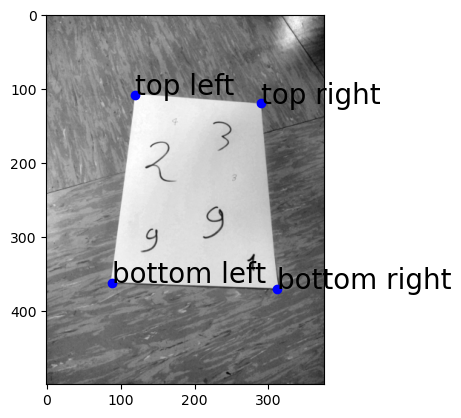

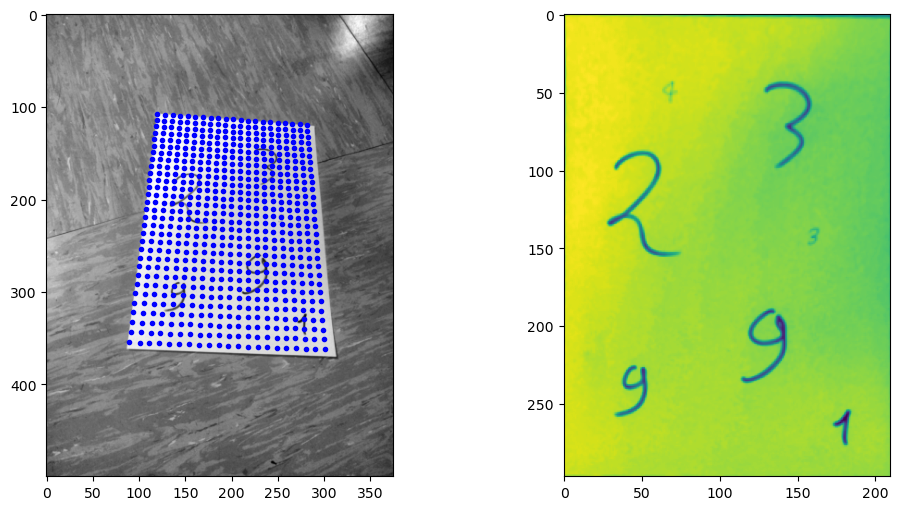

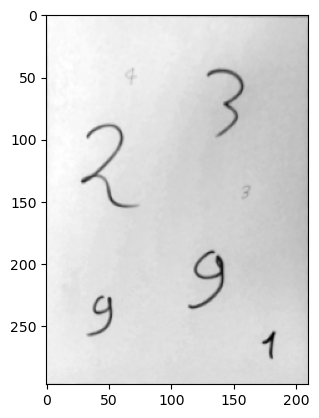

In [98]:
import numpy as np
import skimage.transform
import matplotlib.pyplot as plt
from skimage import io, color, feature, transform, measure, exposure


def assign_edges(intersections):
    """
    Identify the corners of the paper and return them in the following order:
    """
    intersection_to_assign = intersections.copy()

    # Determine top left corner (min distance to the origin)
    tl = min(intersection_to_assign, key=lambda point: np.linalg.norm(np.array(point)))
    intersection_to_assign.remove(tl)
    print(f"Top left: {tl}")

    # Determine bottom right corner (min distance to the origin)
    br = max(intersection_to_assign, key=lambda point: np.linalg.norm(np.array(point)))
    intersection_to_assign.remove(br)
    print(f"Bottom right: {br}")

    # Determine the bottom left corner (min x-coordinate)
    bl = min(intersection_to_assign, key=lambda point: point[0])
    intersection_to_assign.remove(bl)
    print(f"Bottom left: {bl}")

    # Determine the top right corner: Last remaining point
    tr = intersection_to_assign[0]
    print(f"Top right: {tr}")
    
    return tl, tr, br, bl


def determine_orientation(tl, tr, br, bl, im):
    """
    This function determines the orientation of the paper based on the given corners.
    """
    tl = np.array(tl)
    tr = np.array(tr)
    br = np.array(br)
    bl = np.array(bl)

    # Calculate the distances:
    distance_tl_bl = np.linalg.norm(tl - bl)
    distance_tr_br = np.linalg.norm(tr - br)
    average_distance_from_bottom_to_top = (distance_tl_bl + distance_tr_br) / 2

    distance_tl_tr = np.linalg.norm(tl - tr)
    distance_bl_br = np.linalg.norm(bl - br)
    average_distance_from_left_to_right = (distance_tl_tr + distance_bl_br) / 2

    # Determine the orientation: 
    if average_distance_from_bottom_to_top > average_distance_from_left_to_right:
        print("The paper is in portrait orientation.")
        top_left = tl
        bottom_left = bl
        bottom_right = br
        top_right = tr
    else:
        print("The paper is in landscape orientation.")
        top_left = bl
        bottom_left = br
        bottom_right = tr
        top_right = tl

        print(f"Top left: {top_left}")
        print(f"Bottom left: {bottom_left}")
        print(f"Bottom right: {bottom_right}")
        print(f"Top right: {top_right}")

    plt.imshow(im, cmap='gray')
    plt.plot(top_left[0], top_left[1], 'bo')
    plt.text(top_left[0], top_left[1], "top left", color='black', size=20)
    plt.plot(bottom_left[0], bottom_left[1], 'bo')
    plt.text(bottom_left[0], bottom_left[1], "bottom left", color='black', size=20)
    plt.plot(bottom_right[0], bottom_right[1], 'bo')
    plt.text(bottom_right[0], bottom_right[1], "bottom right", color='black', size=20)
    plt.plot(top_right[0], top_right[1], 'bo')
    plt.text(top_right[0], top_right[1], "top right", color='black', size=20)
    plt.show()

    return top_left, top_right, bottom_right, bottom_left

def tranform_image(tl, tr, br, bl, im):
    """
    This function transforms the image to a rectangle with the corners tl, bl, br, tr.
    """

    w, h = 210, 297 # DIN A4 format in pixels

    # Define the edges we will map to:
    TOP_LEFT = np.array([0,0])
    TOP_RIGHT = np.array([w,0])
    BOTTOM_LEFT = np.array([0,h])
    BOTTOM_RIGHT = np.array([w,h])

    # Calculate the transformation matrix:
    invtf  = skimage.transform.estimate_transform('projective', 
                                                    np.vstack([TOP_LEFT, BOTTOM_LEFT, BOTTOM_RIGHT, TOP_RIGHT]),
                                                     np.vstack([tl, bl, br, tr]))


    # Plot the grid on the image:
    fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,6))
    ax1.imshow(im, cmap="gray")
    for x in np.arange(0,w,10):
        for y in np.arange(0,h,10):
            p = invtf((x,y))
            ax1.plot(p[0,0],p[0,1],'b.')


    # Transform the image:
    tim = skimage.transform.warp(image=im, 
                             inverse_map=invtf, 
                             output_shape=(h,w) # columns,rows
    )
    # Set the background to the average color of the image:
    tim[tim == 0] = tim.mean()
    ax2.imshow(tim)
    plt.show()

    return tim


tl, tr, br, bl = assign_edges(intersection_3)
tl, tr, br, bl = determine_orientation(tl, tr, br, bl, im3)
transformed_image = tranform_image(tl, tr, br, bl, im3)

# Show the transformed image:
plt.imshow(transformed_image, cmap="gray")


It seems to work with most pictures well. However we cannot detect if the image is on its head however. We will now continue with the processing here. Binarize and find connected components (this might be tricky when illumination is uneven. How to fix that?).

Information:
A **connected component** refers to a group of adjacent True values in a mask. These groups or "islands" are **labeled** distinctly, while the background is labeled as 0. Each group represents a set of neighboring elements that share the same value

We will now use the `label` function from `skimage.measure` to find the connected components. We will then use the `regionprops` function to find the bounding boxes of the connected components. We will then use the bounding boxes to crop the images. We will then resize the images to 28x28 pixels and then save them to a folder.



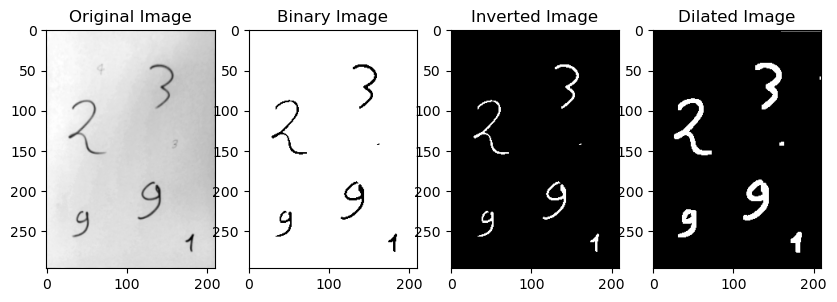

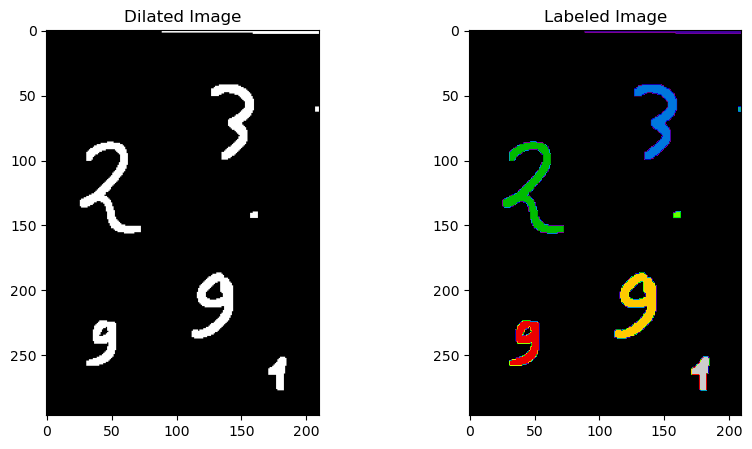

In [110]:
from skimage import io, color, feature, transform, measure, exposure
from skimage.filters import gaussian, threshold_otsu
from skimage.morphology import dilation, square

import skimage.filters
from skimage.morphology import dilation, square
from skimage import exposure, measure
import matplotlib.pyplot as plt

def binarize_and_dialate(warped):
    # Boost contrast
    alpha = 1
    boosted_contrast = alpha * warped + (1 - alpha) * exposure.equalize_hist(warped)
    
    # Binarize image
    thresh = skimage.filters.threshold_otsu(boosted_contrast)
    binary_image = boosted_contrast > thresh

    # Invert image (assuming it means making a binary inverse)
    inverted_image = ~binary_image

    # Dilate image
    dilated_image = dilation(inverted_image, square(4))

    # Plotting
    fig, ax = plt.subplots(1, 4, figsize=(10, 5))
    ax[0].imshow(warped, cmap="gray")
    ax[0].set_title('Original Image')
    ax[1].imshow(binary_image, cmap="gray")
    ax[1].set_title('Binary Image')
    ax[2].imshow(inverted_image, cmap="gray")
    ax[2].set_title('Inverted Image')
    ax[3].imshow(dilated_image, cmap="gray")
    ax[3].set_title('Dilated Image')
    plt.show()

    return dilated_image

def label_images(dilated_image):
    # Perform connected component analysis
    labeled_image = measure.label(dilated_image)

    # Plotting
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(dilated_image, cmap="gray")
    ax[0].set_title('Dilated Image')
    ax[1].imshow(labeled_image, cmap="nipy_spectral")
    ax[1].set_title('Labeled Image')
    plt.show()

    return labeled_image

# Example usage:
dilated_image = binarize_and_dialate(transformed_image)
labeled_image = label_images(dilated_image)
